In [1]:
!pip install langgraph langchain langchain-google-genai

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph,START,END
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import BaseMessage,AIMessage,HumanMessage
from typing import TypedDict,List,Annotated
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
import os
load_dotenv()

True

In [3]:
class BotState(TypedDict):
  messages: Annotated[List[BaseMessage],add_messages]

In [4]:
apikey=os.getenv('GEMINI_API_KEY')

In [5]:
model=ChatGoogleGenerativeAI(model='gemini-2.5-flash', api_key=apikey)

In [6]:
def HandleMessage(BotState):
  result=model.invoke(BotState['messages'])
  print(result.content)
  return {'messages':[AIMessage(content=result.content)]}

In [30]:
checkpointer=InMemorySaver()

In [8]:
graph=StateGraph(BotState)

In [9]:
graph.add_node('message_came',HandleMessage)

In [10]:
graph.add_edge(START,'message_came')
graph.add_edge('message_came',END)

In [12]:
[HumanMessage(content='hello')]

[HumanMessage(content='hello', additional_kwargs={}, response_metadata={})]

#### persistence configuration

In [13]:
thread_id='1'

In [14]:
config={"configurable": {"thread_id": thread_id}}

In [15]:
workflow=graph.compile(checkpointer=checkpointer)

In [17]:
workflow.invoke({'messages':[HumanMessage(content='My name is umair')]},config=config)

Okay, Umair! It's nice to meet you.

Thanks for letting me know. I'll remember that you go by Umair during our conversation. Just to be clear, I don't store personal information, so I won't remember it for future chats, but I'll use it while we're talking now.

How can I help you today, Umair?


{'messages': [HumanMessage(content='what is my name ', additional_kwargs={}, response_metadata={}, id='e50d55ff-ca19-49e4-b992-6c3167745cc3'),
  AIMessage(content="As an AI, I don't know your name because I don't have access to your personal information or identity. Our conversations are anonymous.\n\nIf you'd like me to refer to you by a specific name during our chat, feel free to tell me what it is!", additional_kwargs={}, response_metadata={}, id='681c1411-397e-49dc-a93f-d810e13c5019'),
  HumanMessage(content='My name is umair', additional_kwargs={}, response_metadata={}, id='545b9a4e-38ec-42bf-80ec-c9e64022bc46'),
  AIMessage(content="Okay, Umair! It's nice to meet you.\n\nThanks for letting me know. I'll remember that you go by Umair during our conversation. Just to be clear, I don't store personal information, so I won't remember it for future chats, but I'll use it while we're talking now.\n\nHow can I help you today, Umair?", additional_kwargs={}, response_metadata={}, id='06f3

# Fault Tolerance

In [81]:
import time
graph=StateGraph(workflowState)

In [82]:
class workflowState(TypedDict):
      start:str
      state1:str
      state2:str
      state3:str

In [83]:
def state1(workflowState):
  return {'state1':'done'}

def state2(workflowState):
  time.sleep(10)
  return {'state2':'done'}

def state3(workflowState):
  return {'state3':'done'}

In [84]:
graph.add_node('state1',state1)
graph.add_node('state2',state2)
graph.add_node('state3',state3)

graph.add_edge(START,'state1')
graph.add_edge('state1','state2')
graph.add_edge('state2','state3')
graph.add_edge('state3',END)

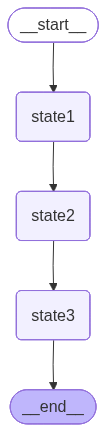

In [85]:
workflow=graph.compile(checkpointer=InMemorySaver())
workflow

In [86]:
threadno='2'
config={"configurable": {"thread_id": threadno}}

In [87]:
workflow.invoke({'start':'start'},config=config)

KeyboardInterrupt: 

In [94]:
# In the above we have seen that our execution is interupted when node 2 is executing,
# so with the help of persistence we have saved all the executed state,
# so now we can resume execution form last executed node

In [88]:
history=workflow.get_state_history(config)
for step in history:
   print(step)

StateSnapshot(values={'start': 'start', 'state1': 'done'}, next=('state2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0cc319-0995-6de4-8001-01578e8daf8c'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-11-28T08:09:29.991609+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0cc319-098f-6c66-8000-f5db58bc918a'}}, tasks=(PregelTask(id='56e7d419-2c5a-734c-862e-6068cc8f1da9', name='state2', path=('__pregel_pull', 'state2'), error=None, interrupts=(), state=None, result=None),), interrupts=())
StateSnapshot(values={'start': 'start'}, next=('state1',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0cc319-098f-6c66-8000-f5db58bc918a'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-11-28T08:09:29.989418+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0cc319-098a-6

In [92]:
# Started execution from checkpoint_id=1f0cc319-0995-6de4-8001-01578e8daf8c (node start1 executed)
workflow.invoke(None,{"configurable": {"thread_id": threadno, 'checkpoint_id': '1f0cc319-0995-6de4-8001-01578e8daf8c'}})

{'start': 'start', 'state1': 'done', 'state2': 'done', 'state3': 'done'}

In [91]:
workflow.get_state_history(config)

<generator object Pregel.get_state_history at 0x7d19ea29f060>

In [93]:
history=workflow.get_state_history(config)
for step in history:
   print(step)

StateSnapshot(values={'start': 'start', 'state1': 'done', 'state2': 'done', 'state3': 'done'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0cc325-83d1-63d4-8003-7427ea0ceda5'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-11-28T08:15:04.931404+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0cc325-83ce-6797-8002-a182489fd9e7'}}, tasks=(), interrupts=())
StateSnapshot(values={'start': 'start', 'state1': 'done', 'state2': 'done'}, next=('state3',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0cc325-83ce-6797-8002-a182489fd9e7'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-11-28T08:15:04.930262+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0cc319-0995-6de4-8001-01578e8daf8c'}}, tasks=(PregelTask(id='61f7b98b-76c7-57b7-6bac-92bbf4a0b53f', name=

#  Time Travel

In [120]:
import operator
graph=StateGraph(state)

In [121]:
class state(TypedDict):
  topic:str
  poetry:Annotated[List[str],operator.add]
  joke:Annotated[List[str],operator.add]

In [122]:
def taketopic(state):
  topic=input('specify topic for generating poetry :')
  return {'topic':topic}

def generatePoetry(state):
  result=model.invoke(f'write a poetry about {state["topic"]}')
  return {'poetry':[result.content]}

def generatejoke(state):
  result=model.invoke(f'write a joke about {state["topic"]}')
  return {'joke':[result.content]}

In [123]:
graph.add_node('taketopic',taketopic)
graph.add_node('generatePoetry',generatePoetry)
graph.add_node('generatejoke',generatejoke)

graph.add_edge(START,'taketopic')
graph.add_edge('taketopic','generatePoetry')
graph.add_edge('generatePoetry','generatejoke')
graph.add_edge('generatejoke',END)

In [124]:
thread_no='6'
config={"configurable": {"thread_id": thread_no}}
workflow=graph.compile(checkpointer=InMemorySaver())

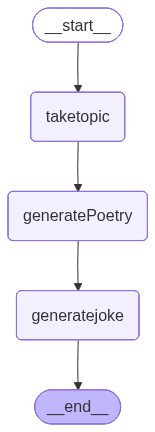

In [125]:
workflow

## when we runned it, workflow ask for the topic and generate both poetry and joke on it

In [126]:
workflow.invoke({},config=config)

specify topic for generating poetry :python


{'topic': 'python',
 'poetry': ["From a serpent's name, a language springs,\nNot scaled or fanged, but logic's grace,\nWhere clarity its simple message brings,\nAnd whitespace carves its rightful place.\n\nNo curly braces to confuse the eye,\nJust clean indentation, neat and deep,\nA gentle flow beneath a boundless sky,\nWhere code's true meaning it will keep.\n\nFrom web's intricate and vast domain,\nTo data's ocean, deep and wide,\nIt orchestrates with steady hand,\nWith countless libraries by its side.\n\nWith NumPy's might and Pandas' grace,\nAnd Django's structure, clean and grand,\nIt builds the future, sets the pace,\nA universal, helping hand.\n\nFor novice hands, a gentle guide,\nFor seasoned pros, a potent tool,\nA vibrant community, open wide,\nWhere learning thrives, and passions rule.\n\nOh, Python, language of the bright,\nYour elegant and humble creed,\nYou turn complex problems into light,\nA paradigm for all to heed."],
 'joke': ['Why was the Python program always so p

In [127]:
list(workflow.get_state_history(config))

[StateSnapshot(values={'topic': 'python', 'poetry': ["From a serpent's name, a language springs,\nNot scaled or fanged, but logic's grace,\nWhere clarity its simple message brings,\nAnd whitespace carves its rightful place.\n\nNo curly braces to confuse the eye,\nJust clean indentation, neat and deep,\nA gentle flow beneath a boundless sky,\nWhere code's true meaning it will keep.\n\nFrom web's intricate and vast domain,\nTo data's ocean, deep and wide,\nIt orchestrates with steady hand,\nWith countless libraries by its side.\n\nWith NumPy's might and Pandas' grace,\nAnd Django's structure, clean and grand,\nIt builds the future, sets the pace,\nA universal, helping hand.\n\nFor novice hands, a gentle guide,\nFor seasoned pros, a potent tool,\nA vibrant community, open wide,\nWhere learning thrives, and passions rule.\n\nOh, Python, language of the bright,\nYour elegant and humble creed,\nYou turn complex problems into light,\nA paradigm for all to heed."], 'joke': ['Why was the Python

In [130]:
workflow.get_state(config={"configurable": {"thread_id": thread_no,'checkpoint_id': '1f0cc47e-b804-6917-8002-7efa2dba7b42'} })


StateSnapshot(values={'topic': 'python', 'poetry': ["From a serpent's name, a language springs,\nNot scaled or fanged, but logic's grace,\nWhere clarity its simple message brings,\nAnd whitespace carves its rightful place.\n\nNo curly braces to confuse the eye,\nJust clean indentation, neat and deep,\nA gentle flow beneath a boundless sky,\nWhere code's true meaning it will keep.\n\nFrom web's intricate and vast domain,\nTo data's ocean, deep and wide,\nIt orchestrates with steady hand,\nWith countless libraries by its side.\n\nWith NumPy's might and Pandas' grace,\nAnd Django's structure, clean and grand,\nIt builds the future, sets the pace,\nA universal, helping hand.\n\nFor novice hands, a gentle guide,\nFor seasoned pros, a potent tool,\nA vibrant community, open wide,\nWhere learning thrives, and passions rule.\n\nOh, Python, language of the bright,\nYour elegant and humble creed,\nYou turn complex problems into light,\nA paradigm for all to heed."], 'joke': []}, next=('generatej

In [129]:
# now our goal is to again generate only the joke, we are skipping the generating poetry,
# so according to time travel we are jumping to the poetry step
# so we should want to exectue only the node generatejoke and onwards

In [131]:
workflow.invoke(None,config={"configurable": {"thread_id": thread_no,'checkpoint_id': '1f0cc47e-b804-6917-8002-7efa2dba7b42'}})


{'topic': 'python',
 'poetry': ["From a serpent's name, a language springs,\nNot scaled or fanged, but logic's grace,\nWhere clarity its simple message brings,\nAnd whitespace carves its rightful place.\n\nNo curly braces to confuse the eye,\nJust clean indentation, neat and deep,\nA gentle flow beneath a boundless sky,\nWhere code's true meaning it will keep.\n\nFrom web's intricate and vast domain,\nTo data's ocean, deep and wide,\nIt orchestrates with steady hand,\nWith countless libraries by its side.\n\nWith NumPy's might and Pandas' grace,\nAnd Django's structure, clean and grand,\nIt builds the future, sets the pace,\nA universal, helping hand.\n\nFor novice hands, a gentle guide,\nFor seasoned pros, a potent tool,\nA vibrant community, open wide,\nWhere learning thrives, and passions rule.\n\nOh, Python, language of the bright,\nYour elegant and humble creed,\nYou turn complex problems into light,\nA paradigm for all to heed."],
 'joke': ["Here's one:\n\nWhy did the Python deve

In [133]:
list(workflow.get_state_history(config))

[StateSnapshot(values={'topic': 'python', 'poetry': ["From a serpent's name, a language springs,\nNot scaled or fanged, but logic's grace,\nWhere clarity its simple message brings,\nAnd whitespace carves its rightful place.\n\nNo curly braces to confuse the eye,\nJust clean indentation, neat and deep,\nA gentle flow beneath a boundless sky,\nWhere code's true meaning it will keep.\n\nFrom web's intricate and vast domain,\nTo data's ocean, deep and wide,\nIt orchestrates with steady hand,\nWith countless libraries by its side.\n\nWith NumPy's might and Pandas' grace,\nAnd Django's structure, clean and grand,\nIt builds the future, sets the pace,\nA universal, helping hand.\n\nFor novice hands, a gentle guide,\nFor seasoned pros, a potent tool,\nA vibrant community, open wide,\nWhere learning thrives, and passions rule.\n\nOh, Python, language of the bright,\nYour elegant and humble creed,\nYou turn complex problems into light,\nA paradigm for all to heed."], 'joke': ["Here's one:\n\nWhy